# Dense and Sparse Matrices in Julia

This lecture will be about linear algebra in Julia, but almost everything we discuss will be equally applicable to other languages.  You almost never write your own basic linear-algebra routines these days, in any language — it is all about formulating your problem to exploit fast libraries, choosing the right algorithm, selecting good preconditioners (for iterative solvers) and so on.

That being said, there are a few nice things about linear-algebra that are relatively unusual in Julia, including a rich library of specialized matrix types, the ability to do linear-algebra with user-defined arithmetic type, and the ability to directly call low-level specialized routines from LAPACK and other libraries when needed.

In [1]:
using PyPlot, BenchmarkTools, Interact # some useful packages

"""
Like `@benchmark`, but returns only the minimum time in seconds,
similar to Julia's built-in `@elapsed` macro.
"""
macro belapsed(args...)
    b = Expr(:macrocall, Symbol("@benchmark"), map(esc, args)...)
    :(1e-9 * time(minimum($b)))
end

@belapsed

# Dense-matrix operations

In [2]:
\, lu, lufact, chol, cholfact, qr, qrfact, eigvals, eig, svd # some important functions

(\,lu,lufact,chol,cholfact,qr,qrfact,eigvals,eig,svd)

In [1]:
A = rand(1000,1000)
@time lu(A)
@time lufact(A)
@time inv(A);

  0.264575 seconds (219.80 k allocations: 32.231 MB, 1.86% gc time)
  0.013325 seconds (270 allocations: 7.652 MB)
  0.156801 seconds (74.31 k allocations: 18.901 MB, 2.99% gc time)


In [5]:
A = rand(1000,1000); A = A' * A # make a random symmetric positive-definite (SPD) matrix
@time lufact(A)
@time cholfact(A) # Cholesky factorization

  0.012490 seconds (11 allocations: 7.637 MB)
  0.068003 seconds (12 allocations: 7.630 MB, 81.48% gc time)


Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[18.5295 14.6027 … 14.0934 13.9077; 0.0 12.0747 … 4.59456 4.8984; … ; 0.0 0.0 … 0.300247 0.706918; 0.0 0.0 … 0.0 0.0133583]

## Scaling

In [4]:
BLAS.set_num_threads(1) # don't want multi-threading to confuse our comparisons

In [5]:
A = rand(100,100)
t100 = [@belapsed(lufact($A), evals=1), @belapsed(qrfact($A), evals=1), 
        @belapsed(eigvals($A), evals=1), @belapsed(eig($A), evals=1), @belapsed(svd($A), evals=1)]

5-element Array{Float64,1}:
 0.000168878
 0.000918561
 0.0163504  
 0.030489   
 0.0181878  

In [6]:
t100 / t100[1] # time scaled by LU factorization time

5-element Array{Float64,1}:
   1.0   
   5.4392
  96.818 
 180.539 
 107.698 

In [7]:
A = rand(1000,1000)
t1000 = [@belapsed(lufact($A), evals=1), @belapsed(qrfact($A), evals=1), 
         @belapsed(eigvals($A), evals=1), @belapsed(eig($A), evals=1), @belapsed(svd($A), evals=1)]

5-element Array{Float64,1}:
 0.0249065
 0.10707  
 1.55811  
 3.1642   
 0.824115 

In [8]:
t1000 / t1000[1]

5-element Array{Float64,1}:
   1.0    
   4.29889
  62.5584 
 127.043  
  33.0884 

In [9]:
t1000 ./ (t100 * 10^3)

5-element Array{Float64,1}:
 0.147482 
 0.116563 
 0.0952947
 0.103782 
 0.0453114

So much for $n^3$ scaling?   But maybe this is some kind of overhead that affects
small matrices, so we could compare to matrices of a more similar size?

In [10]:
A = rand(2000,2000)
t2000 = [@belapsed(lufact($A), evals=1), @belapsed(qrfact($A), evals=1), 
         @belapsed(eigvals($A), evals=1), @belapsed(eig($A), evals=1), @belapsed(svd($A), evals=1)]

5-element Array{Float64,1}:
  0.165081
  0.615574
  7.19482 
 18.4063  
  5.89631 

In [11]:
t2000 ./ (t1000 * 2^3)

5-element Array{Float64,1}:
 0.828505
 0.718657
 0.577207
 0.727132
 0.89434 

Okay, this is closer to $n^3$ scaling, at least, though it is still doing slightly better than it "should".   (I wonder if it is using multiple threads even though I told it not to?)

Now, to scale from this to solving a $200000 \times 200000$ system of equations should require:

In [12]:
t2000[1] * 100^3 / 86400 # scale by 100^3 and divide by seconds/day

1.9106621875000003

Yikes, almost 2 days.  Worse, we run out of memory before we run out of time:

In [13]:
sizeof(Float64) * 200000^2 / 2^30 # size in GB

298.0232238769531

I don't have 300GB of RAM on my laptop!   You **often run out of memory before you run out of time** in large matrix problems.

And yet, we *will* solve such a system of equations, below, in less than 2 seconds with less than 1GB of memory.   The key is that *really* large systems of equations usually have some structure that you can exploit, the most common of which is *sparsity*.

# Sparse matrices

See accompanying [nested dissection and sparse matrices](Nested-Dissection.ipynb) notebook.

## Example: Vibrating modes of a drum

As an example, let's consider $\hat{A} = -\nabla\cdot c\nabla$ for some $c(\vec{x}) > 0$, which is self-adjoint and positive-definite for any finite domain $\Omega$ with Dirichlet boundary conditions $u|_{\partial\Omega}=0$ and the usual inner product $\langle u, v \rangle = \int_\Omega \bar{u} v$.

(This is an example taken from the class [18.303: Linear Partial Differential Equations](http://math.mit.edu/~stevenj/18.303/) at MIT.)

We'll define the finite-difference discretization by allowing the user to pass
in 1d arrays `x` and `y` of the $x$ and $y$ coordinates used in the
discretization (possibly nonuniformly spaced!), *including* the coordinates of the endpoints where $u$ is zero.  We'll also allow the user to pass in an arbitrary *function* $c(x,y)$ that we'll evaluate on the grid as needed, defaulting to `c=1`:

In [14]:
# compute the first-derivative finite-difference matrix
# for Dirichlet boundaries, given a grid x[:] of x points
# (including the endpoints where the function = 0!).
function sdiff1(x)
    N = length(x) - 2
    dx1 = Float64[1/(x[i+1] - x[i]) for i = 1:N]
    dx2 = Float64[-1/(x[i+1] - x[i]) for i = 2:N+1]
    spdiagm((dx1,dx2), (0,-1), N+1, N)
end

flatten(X) = reshape(X, length(X))

# compute the -∇⋅ c ∇ operator for a function c(x,y)
# and arrays x[:] and y[:] of the x and y points,
# including the endpoints where functions are zero
# (i.e. Dirichlet boundary conditions).
function Laplacian(x, y, c = (x,y) -> 1.0)
    Dx = sdiff1(x)
    Nx = size(Dx,2)
    Dy = sdiff1(y)
    Ny = size(Dy,2)
    
    # discrete Gradient operator:
    G = [kron(speye(Ny), Dx); kron(Dy, speye(Nx))]
    
    # grids for derivatives in x and y directions
    x′ = [0.5*(x[i]+x[i+1]) for i = 1:length(x)-1]
    y′ = [0.5*(y[i]+y[i+1]) for i = 1:length(y)-1]
    
    # evaluate c(x)
    C = spdiagm([ flatten(Float64[c(X,Y) for X in x′, Y in y[2:end-1]]);
                  flatten(Float64[c(X,Y) for X in x[2:end-1], Y in y′]) ])
    
    return G' * C * G # -∇⋅ c ∇
end

Laplacian (generic function with 2 methods)

Now, let's consider the usual $-\nabla^2$ operator, but use an oddly shaped domain, using the trick  of defining a discretization over a box and then taking a subset of rows and columns that are inside our domain.

We'll define an odd spiral-shaped domain as the intersection of the box $[-1,1]\times[-1,1]$ with the region where a [level-set function](https://en.wikipedia.org/wiki/Level_set_method) $\varphi(x,y)$ is $>0$.

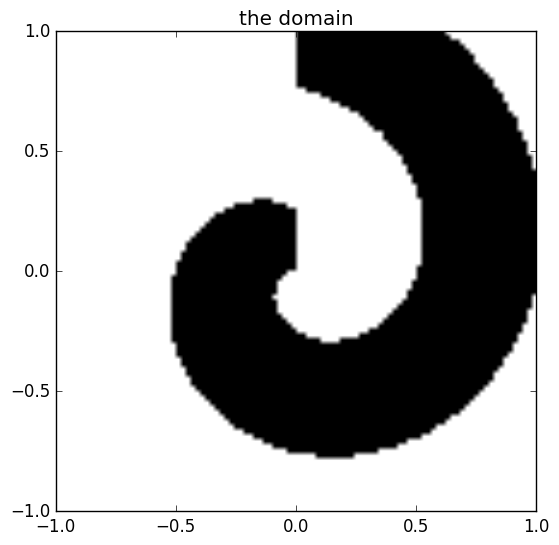

PyObject <matplotlib.text.Text object at 0x1066abe10>

In [15]:
N = 100
x = linspace(-1,1,N+2)[2:end-1]
y = x'  # a row vector
r = sqrt(x.^2 .+ y.^2)     # use broadcasting (.+) to make Nx x Ny matrix of radii
θ = broadcast(atan2, y, x) # and angles
φ = exp(-(r - θ*0.5/π - 0.5).^2 / 0.3^2) - 0.5
imshow(φ .> 0, extent=[-1,1,-1,1], cmap="binary")
title("the domain")

Now we'll compute the eigenfunctions.  We'll use the [Interact package](https://github.com/JuliaLang/Interact.jl) to interactively decide which eigenvalue to plot.

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(10, nactions=1),"which_eig",10,"10",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(18=>"18",2=>"2",16=>"16",11=>"11",7=>"7",9=>"9",10=>"10",19=>"19",17=>"17",8=>"8"…)),Any[],Any[],true,"horizontal")

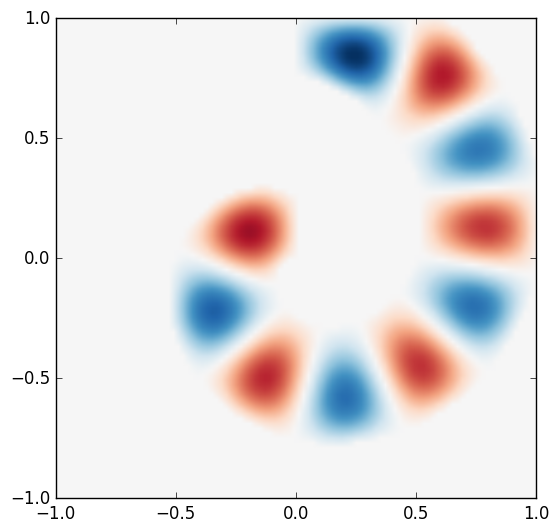

In [16]:
x0 = linspace(-1,1,N+2) # includes boundary points, unlike x
Abox = Laplacian(x0, x0, (x,y) -> 1.0);
i = find(φ .> 0)
A = Abox[i,i]
u = zeros(N,N)
λ, X = eigs(A, nev=20, which=:SM);

f = figure()
@manipulate for which_eig in 1:20
    withfig(f) do
        u[i] = X[:,which_eig]
        umax = maxabs(u)
        imshow(u, extent=[-1,1,-1,1], vmin=-umax,vmax=+umax, cmap="RdBu")
    end
end

## Example: Helmholtz solver

The following code solves a **scalar Helmholtz** equation

$$
\left[ -\nabla^2 - \omega^2 \varepsilon(x,y) \right] u = f(x,y)
$$

For example, this equation corresponds to *2d electromagntic waves* (with "natural" $c=1$ units) where $\varepsilon$ is the relative permittivity, $\omega$ is the frequency, $u$ is the electric-field component $E_z$, and $f$ is an electric-current density in the $z$ direction.

We discretize this into a matrix equation $Au=f$ with a "staggered" finite-difference grid (this is an [FDFD method](https://en.wikipedia.org/wiki/Finite-difference_frequency-domain_method)) with `resolution` pixels per unit distance (usually chosen to be at least 10 pixels per wavelength $\lambda = 2\pi/\omega$).   We solve it in a finite $L_x \times L_y$ box, with [PML](https://en.wikipedia.org/wiki/Perfectly_matched_layer) of thickness `dpml` around the exterior to absorb outgoing waves.  The user specifies
$\varepsilon(x,y)$ by passing a *function* argument, where $(0,0)$ is the coordinate at the center of the computational cell.

There is a nice trick to assemble the `A` matrices via smaller "1d" discretizations via [Kronecker products](https://en.wikipedia.org/wiki/Kronecker_product).

In [17]:
"""
Return `(A,Nx,Ny,x,y)` for the 2d Helmholtz problem.
"""
function Helmholtz2d(Lx, Ly, ε, ω; dpml=2, resolution=20, Rpml=1e-20)
    # PML σ = σ₀ x²/dpml², with σ₀ chosen so that
    # the round-trip reflection is Rpml:
    σ₀ = -log(Rpml) / (4dpml/3)
    
    M = round(Int, (Lx+2dpml) * resolution)
    N = round(Int, (Ly+2dpml) * resolution)
    dx = (Lx+2dpml) / (M+1)
    dy = (Ly+2dpml) / (N+1)
    x = (1:M) * dx - Lx/2 - dpml # x grid, centered
    y = (1:N) * dy - Ly/2 - dpml # y grid, centered
    
    # 1st-derivative matrix
    x′ = ((0:M) + 0.5)*dx # 1st-derivative grid points
    y′ = ((0:N) + 0.5)*dy # 1st-derivative grid points
    ox = ones(M)/dx
    oy = ones(N)/dy
    σx = Float64[ξ < dpml ? σ₀*(dpml-ξ)^2 : ξ > Lx+dpml ? σ₀*(ξ-(Lx+dpml))^2 : 0.0 for ξ in x′]
    σy = Float64[ξ < dpml ? σ₀*(dpml-ξ)^2 : ξ > Ly+dpml ? σ₀*(ξ-(Ly+dpml))^2 : 0.0 for ξ in y′]
    Dx = spdiagm(1./(1+(im/ω)*σx)) * spdiagm((-ox,ox),(-1,0),M+1,M)
    Dy = spdiagm(1./(1+(im/ω)*σy)) * spdiagm((-oy,oy),(-1,0),N+1,N)
    Ix = speye(M)
    Iy = speye(N)
    return (kron(Ix, Dy.'*Dy) + kron(Dx.'*Dx, Iy) -
            spdiagm(reshape(Complex128[ω^2 * ε(ξ, ζ) for ζ in y, ξ in x], length(x)*length(y))),
            M, N, x, y)
end

Helmholtz2d

Let's set up a scattering problem with a cylindrical scatterer (ε=12 inside a diameter-1 cylinder in the center, and ε=1 elsewhere, with a wavelength $2\pi/\omega$ of 1):

In [18]:
A, Nx, Ny, x, y = Helmholtz2d(20,20, (x,y) -> hypot(x,y) < 0.5 ? 12 : 1, 2π)
size(A), nnz(A) / size(A,1)

((230400,230400),4.991666666666666)

For the right-hand side `b`, let's use a "point" source on one side.
We'll use the `reshape` function to convert between 2d arrays and
column vectors for solving with `A`.  Note that the solution is complex, since it corresponds physically to an oscillating solution $u(x,y)e^{-i\omega t}$ and $u$ has a phase angle due to the absorbing boundary layers (which make `A` non-Hermitian); we'll just plot the real part.

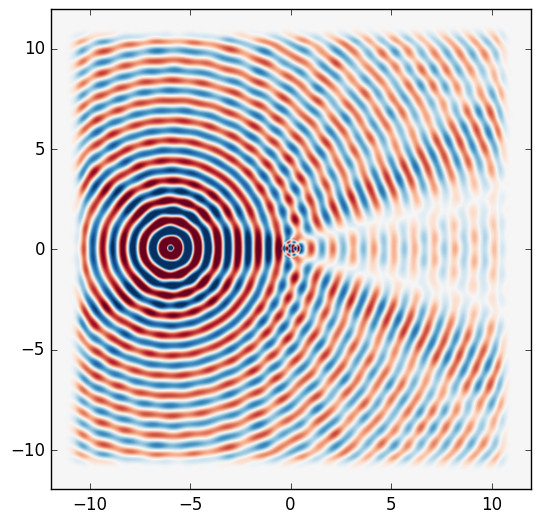

In [19]:
b = zeros(Nx,Ny)
b[Nx÷2, Ny÷4] = 1
@time u = reshape(A \ reshape(b, Nx*Ny), Nx, Ny)
s = maxabs(real(u)) / 10
imshow(real(u), cmap="RdBu", vmin=-s, vmax=s,
       extent=(minimum(x),maximum(x),minimum(y),maximum(y)))

We solved a $200000\times200000$ matrix problem in about 2 seconds, and less than 1GB of memory.  Pretty good!

# Special sparse matrices in Julia

In [20]:
SymTridiagonal, Diagonal, Tridiagonal, Bidiagonal

(SymTridiagonal{T},Diagonal{T},Tridiagonal{T},Bidiagonal{T})

In [21]:
n = 5
L = diagm(ones(n)*2) - diagm(ones(n-1),-1) - diagm(ones(n-1), 1)

5×5 Array{Float64,2}:
  2.0  -1.0   0.0   0.0   0.0
 -1.0   2.0  -1.0   0.0   0.0
  0.0  -1.0   2.0  -1.0   0.0
  0.0   0.0  -1.0   2.0  -1.0
  0.0   0.0   0.0  -1.0   2.0

In [22]:
n = 1000
L = diagm(ones(n)*2) - diagm(ones(n-1),-1) - diagm(ones(n-1), 1)
b = rand(n)
@belapsed($L \ $b, evals=1) / @belapsed($(sparse(L)) \ $b, evals=1)

94.94193859200718

In [23]:
@belapsed($(sparse(L)) \ $b, evals=1) / @belapsed($(Tridiagonal(L)) \ $b, evals=1)

8.311553613197095

In [24]:
@belapsed($(sparse(L)) \ $b, evals=1) / @belapsed($(SymTridiagonal(L)) \ $b, evals=1)

16.327018221310485

# Iterative solvers

Unfortunately, sparse-direct solvers like those we are using above have two limitations:

* They only work **if the matrix is sparse**.  There are lots of problems where $A$ has some special structure that lets you compute $A*x$ quickly, e.g. by FFTs, and avoid storing the whole matrix, but for which $A$ is not sparse.

* They **scale poorly** if the sparse matrix comes from a **3d grid or mesh**.  For an $s$-element 1d mesh with $n=s$ degrees of freedom, they have $O(s)$ complexity.  For an $s \times s$ 2d mesh with $n=s^2$ degrees of freedom, they take $O(n \log n)$ operations and require $O(n)$ storage.   But for a 3d $s\times s\times s$ mesh with $n = s^3$, they take $O(n^2)$ operations and require $O(n^{4/3})$ storage (and you often run out of storage before you run out of time).

The alternative is an **iterative solver**, in which you supply an initial guess for the solution $x$ (often just $x=0$) and then it *iteratively improves* the guess, converging (hopefully) to the solution $A^{-1} b$, while using *only* matrix-vector operations $Ax$.

Iterative solvers are the method of choice (or, more accurately, of necessity) for the very largest problems, but they have their downsides.  There are *many iterative solver algorithms*, and you have to know a little bit to pick the best one.  They *may not converge at all* for non-symmetric $A$, and in any case may *converge very slowly*, unless you provide a "magic" matrix called a *preconditioner* that is specific to your problem. (It is often a research problem in itself to find a good preconditioner!)

## Toy example: Steepest-descent algorithm

If $A$ is a **real-symmetric positive-definite** matrix, then solving $Ax = b$ is equivalent to minimizing the function:

$$
f(x) = x^T A x - x^T b - b^T x
$$

(Just compute $\nabla f = \cdots = Ax - b$, which equals zero at the minimum.  The definiteness of $A$ means that the function $f$ is convex, so there is exactly one global minimum.)

One of the simplest iterative algorithms is just to **go downhill**: minimize $f(x + \alpha d)$ over $\alpha$, where $d$ is the downhill direction $-\nabla f = b - Ax = r$, where $r$ is called the *residual*.  We can perform this *line minimization* analytically for this $f$, for an arbitrary $d$, to find $\alpha = d^T r / d^T A d$.

The steepest-descent algorithm simply performs this downhill line-minimization repeatedly, starting at an initial guess `x` (typically just `x=0`), e.g. stopping when the norm of the residual is less than some tolerance times the norm of `b`.

In [25]:
function SD(A, b, x=zeros(b); tol=1e-8, maxiters=1000)
    bnorm = norm(b)
    r = b - A*x # initial residual
    rnorm = [norm(r)] # return the array of residual norms
    Ad = zeros(r) # allocate space for Ad
    for i = 1:maxiters
        d = r # use the steepest-descent direction
        A_mul_B!(Ad, A, d) # store matvec A*r in-place in Ar
        α = dot(d, r) / dot(d, Ad)
        x .= x .+ α .* d  # in Julia 0.6, this "fuses" into a single in-place update
        r .= r .- α .* Ad # update the residual (without computing A*x again)
        push!(rnorm, norm(r))
        rnorm[end] ≤ tol*bnorm && break # converged
    end
    return x, rnorm
end

SD (generic function with 2 methods)

In [26]:
A = rand(100,100); A = A'*A # a random SPD matrix
b = rand(100)
x, rnorm = SD(A, b, maxiters=10000)
length(rnorm), rnorm[end]/norm(b)

(10001,0.2473368632037679)

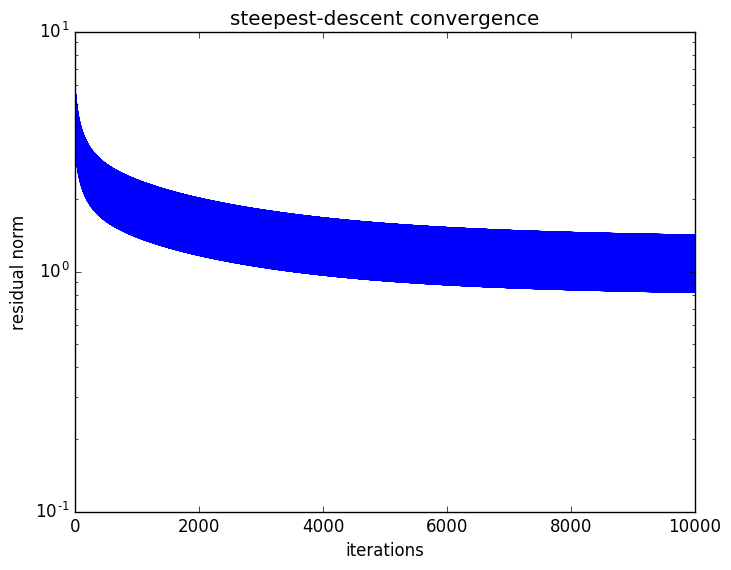

PyObject <matplotlib.text.Text object at 0x321909ed0>

In [27]:
semilogy(rnorm)
title("steepest-descent convergence")
ylabel("residual norm")
xlabel("iterations")

To see what's going on, let's try a $2\times2$ matrix where we can easily visualize the progress.

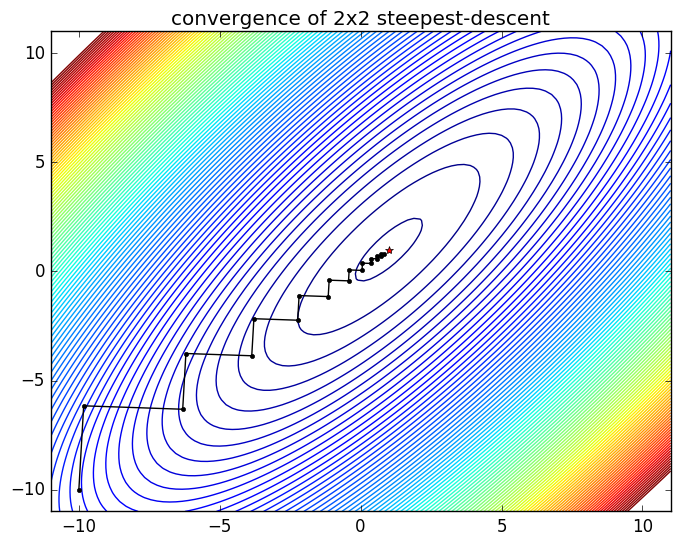

PyObject <matplotlib.text.Text object at 0x321ecbe90>

In [28]:
θ = 0.9 # chosen to make a nice-looking plot
Q = [cos(θ) sin(θ); -sin(θ) cos(θ)] # 2x2 rotation by θ
A = Q * diagm([10,1]) * Q' # a 2x2 matrix with eigenvalues 10,1
b = A * [1,1] # right-hand side for solution (1,1)
x1 = linspace(-11,11,100)
contour(x1', x1, [dot([x1,x2], A*[x1,x2]) - 2*(x1*b[1]+x2*b[2]) for x1 in x1, x2 in x1], levels=linspace(1,2000,100))
plot(1,1, "r*")
x1s = Float64[]
x2s = Float64[]
for i = 0:20
    x, = SD(A, b, [-10.,-10.], maxiters=i)
    push!(x1s, x[1])
    push!(x2s, x[2])
end
plot(x1s, x2s, "k.-")

title("convergence of 2x2 steepest-descent")

## From steepest-descent to conjugate-gradient

In [29]:
function CG(A, b, x=zeros(b); tol=1e-8, maxiters=1000)
    bnorm = norm(b)
    r = b - A*x # initial residual
    rnorm = [norm(r)] # return the array of residual norms
    d = copy(r) # initial direction is just steepest-descent
    Ad = zeros(r) # allocate space for Ad
    for i = 1:maxiters
        A_mul_B!(Ad, A, d) # store matvec A*r in-place in Ar
        α = dot(d, r) / dot(d, Ad)
        x .= x .+ α .* d  # in Julia 0.6, this "fuses" into a single in-place update
        r .= r .- α .* Ad # update the residual (without computing A*x again)
        push!(rnorm, norm(r))
        d .= r .+ d .* (rnorm[end]/rnorm[end-1])^2 # conjugate direction update
        rnorm[end] ≤ tol*bnorm && break # converged
    end
    return x, rnorm
end

CG (generic function with 2 methods)

In [30]:
A = rand(100,100); A = A'*A # a random SPD matrix
b = rand(100)
x, rnorm = CG(A, b)
length(rnorm), rnorm[end]/norm(b)

(211,8.964749160822532e-9)

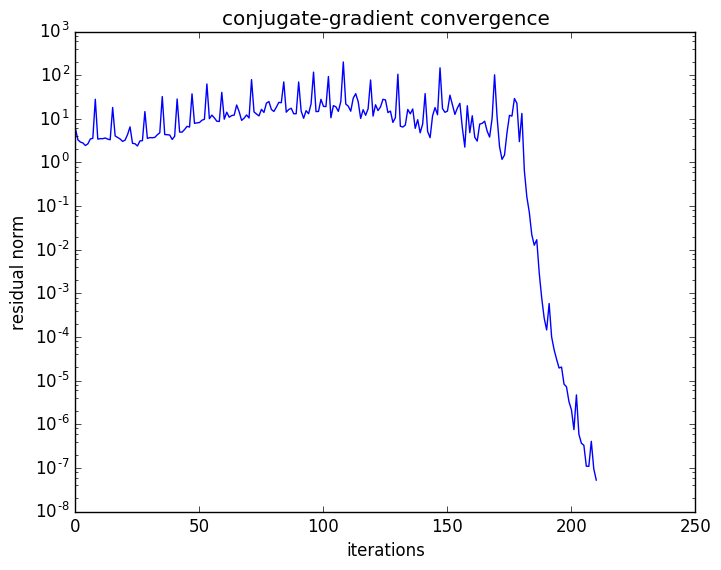

PyObject <matplotlib.text.Text object at 0x323358210>

In [31]:
semilogy(rnorm)
title("conjugate-gradient convergence")
ylabel("residual norm")
xlabel("iterations")

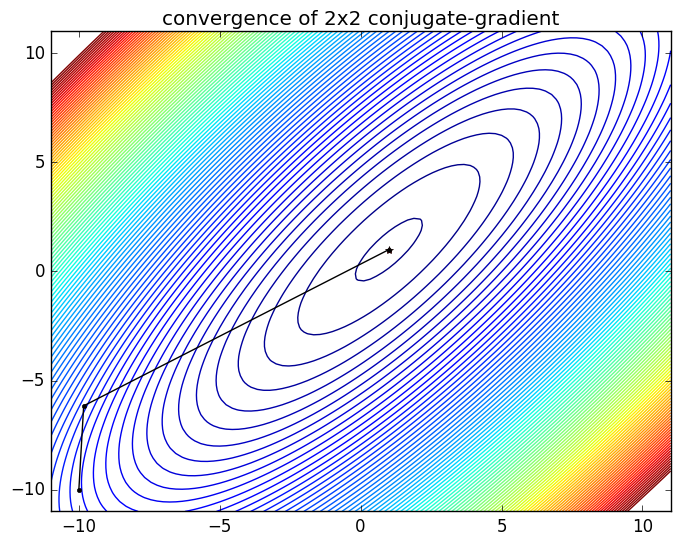

PyObject <matplotlib.text.Text object at 0x3211454d0>

In [32]:
θ = 0.9 # chosen to make a nice-looking plot
Q = [cos(θ) sin(θ); -sin(θ) cos(θ)] # 2x2 rotation by θ
A = Q * diagm([10,1]) * Q' # a 2x2 matrix with eigenvalues 10,1
b = A * [1,1] # right-hand side for solution (1,1)
x1 = linspace(-11,11,100)
contour(x1', x1, [dot([x1,x2], A*[x1,x2]) - 2*(x1*b[1]+x2*b[2]) for x1 in x1, x2 in x1], levels=linspace(1,2000,100))
plot(1,1, "r*")
x1s = Float64[]
x2s = Float64[]
for i = 0:2
    x, = CG(A, b, [-10.,-10.], maxiters=i)
    push!(x1s, x[1])
    push!(x2s, x[2])
end
plot(x1s, x2s, "k.-")

title("convergence of 2x2 conjugate-gradient")

## You don't have to write your own iterative solvers

In [33]:
# do this if you haven't installed it yet: Pkg.add("IterativeSolvers")
using IterativeSolvers

In [34]:
A = rand(100,100); A = A'*A # a random SPD matrix
b = rand(100)
x, ch = cg(A, b, maxiter=300)
norm(A*x - b) / norm(b)

4.357151807537785e-11

In [35]:
dump(ch)

IterativeSolvers.ConvergenceHistory{Float64,Array{Float64,1}}
  isconverged: Bool false
  threshold: Float64 1.2694570371178556e-13
  mvps: Int64 301
  residuals: Array{Float64}((300,)) [3.61997,3.08548,3.07737,3.40512,3.31444,3.40957,3.15654,18.2252,3.74942,4.36105  …  6.99013e-12,1.08254e-11,2.81274e-12,3.31712e-12,1.88435e-12,2.73643e-12,1.25641e-12,6.4229e-12,1.3078e-12,2.80122e-12]


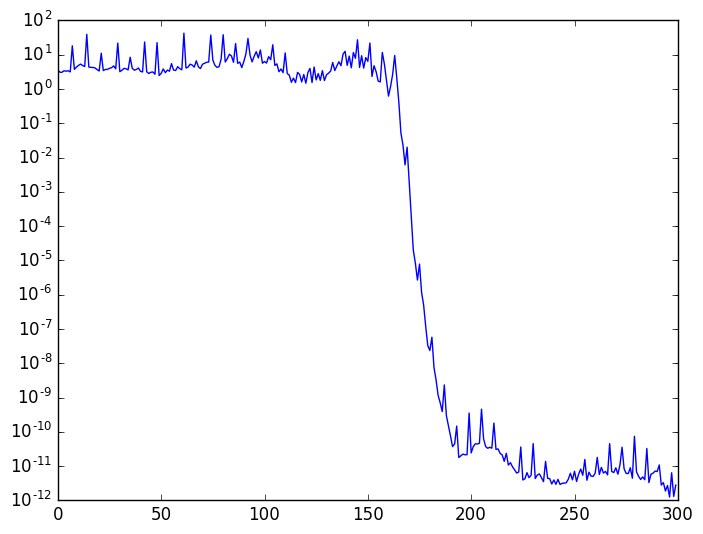

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x323afa0d0>

In [36]:
semilogy(ch.residuals)

### PETSc

PETSc.jl and the PETSc library: large-scale iterative and sparse solvers for distributed-memory parallel systems.

## Preconditioners

Most iterative solvers are *greatly accelerated* if you can provide a *preconditioner*: roughly, an *approximate inverse* of $A$ that is *easy to compute*.  The preconditioner is applied at *every step* of the iteration in order to speed up convergence.